understanding the diffusion process

In [1]:
import torch
from chroma.layers.structure.diffusion import DiffusionChainCov
from chroma.layers.structure import backbone
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from Bio import PDB
import numpy as np

# Set a random seed for reproducibility
torch.manual_seed(42)

/Users/olivier/git/chroma/chroma/layers/graph.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
def load_pdb(pdb_file):
    parser = PDB.PDBParser()
    structure = parser.get_structure("protein", pdb_file)
    
    coords = []
    for model in structure:
        for chain in model:
            for residue in chain:
                if PDB.is_aa(residue):
                    n = residue['N'].get_coord()
                    ca = residue['CA'].get_coord()
                    c = residue['C'].get_coord()
                    o = residue['O'].get_coord() if 'O' in residue else ca  # Use CA coords if O is missing
                    coords.append([n, ca, c, o])
    
    X = torch.tensor(coords, dtype=torch.float32)
    C = torch.ones(X.shape[0], dtype=torch.long)  # Assuming single chain
    
    return {'X': X, 'C': C}

# Load and prepare the data
pdb_data = load_pdb('data/6oim.pdb')
X = pdb_data['X']  # Backbone coordinates
C = pdb_data['C']  # Chain information

# Ensure X and C are on the correct device (CPU or GPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
X = X.to(device)
C = C.to(device)

# Add batch dimension if not present
if X.dim() == 3:
    X = X.unsqueeze(0)
    C = C.unsqueeze(0)

print(f"X shape: {X.shape}")
print(f"C shape: {C.shape}")

X shape: torch.Size([1, 167, 4, 3])
C shape: torch.Size([1, 167])


/var/folders/1r/tcmyxjtj61q0ghzv1qpmkjdc0000gn/T/ipykernel_83660/197765466.py:16: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/_temp/anaconda/conda-bld/pytorch_1711403212643/work/torch/csrc/utils/tensor_new.cpp:278.)
  X = torch.tensor(coords, dtype=torch.float32)


In [3]:
diffusion = DiffusionChainCov()

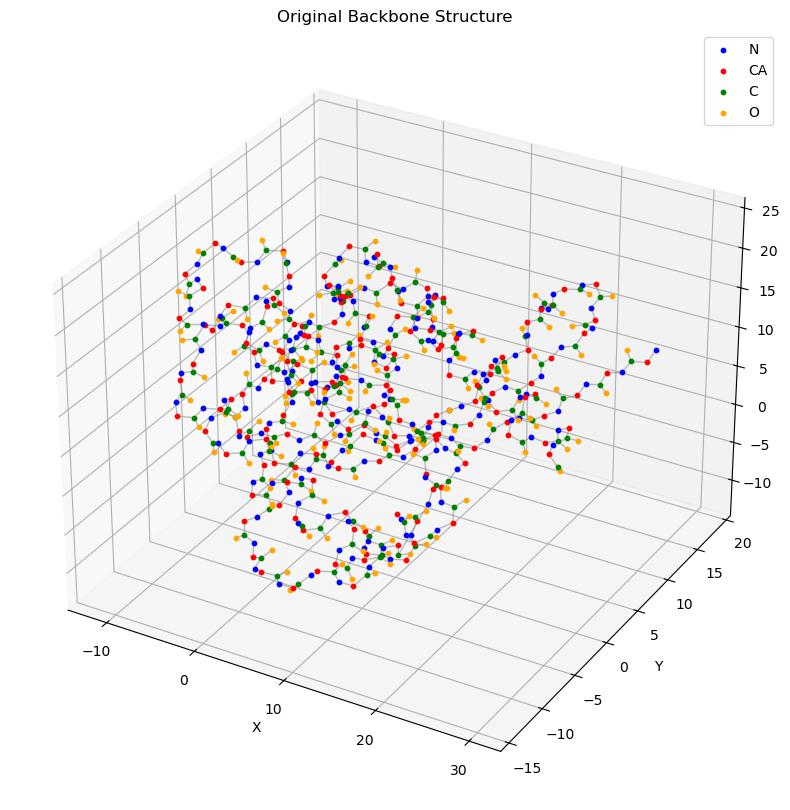

In [4]:
def plot_backbone(X, title):
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    X_np = X.squeeze().cpu().numpy()
    colors = ['blue', 'red', 'green', 'orange']  # Colors for N, CA, C, O respectively
    labels = ['N', 'CA', 'C', 'O']
    for i in range(X_np.shape[0]):
        # Plot backbone atoms for each residue
        ax.plot(X_np[i, :, 0], X_np[i, :, 1], X_np[i, :, 2], '-o', 
                color='gray', alpha=0.5, linewidth=1, markersize=0)
        for j in range(4):
            ax.scatter(X_np[i, j, 0], X_np[i, j, 1], X_np[i, j, 2], 
                       color=colors[j], s=10, label=labels[j] if i == 0 else "")
        
        # Connect C atom of current residue to N atom of next residue
        if i < X_np.shape[0] - 1:
            ax.plot([X_np[i, 2, 0], X_np[i+1, 0, 0]],
                    [X_np[i, 2, 1], X_np[i+1, 0, 1]],
                    [X_np[i, 2, 2], X_np[i+1, 0, 2]],
                    color='gray', alpha=0.5, linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.legend()
    ax.set_title(title)
    plt.show()

# Visualize the original structure
plot_backbone(X, "Original Backbone Structure")

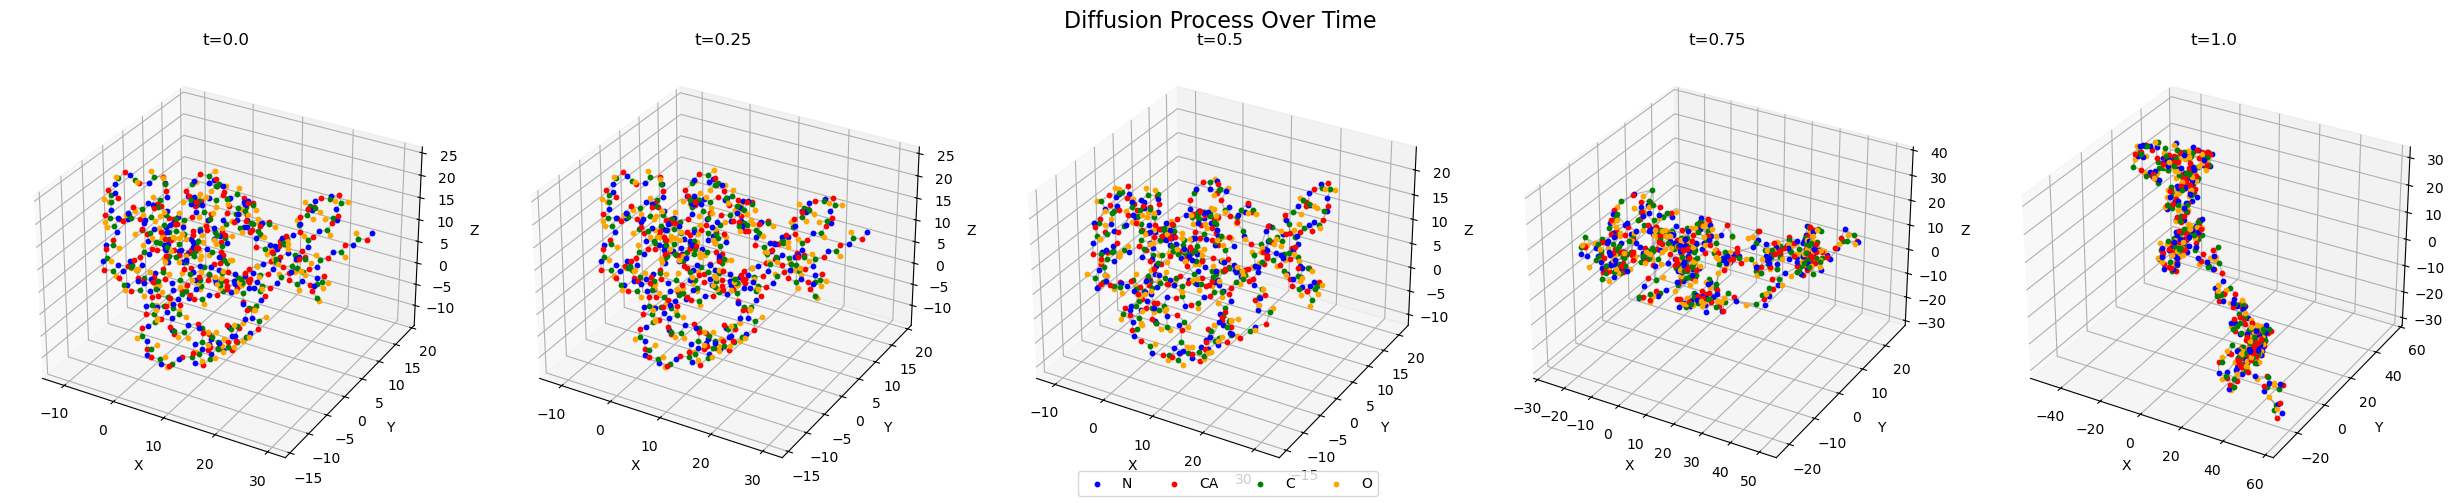

In [5]:
time_steps = [0.0, 0.25, 0.5, 0.75, 1.0]

fig, axes = plt.subplots(1, 5, figsize=(25, 5), subplot_kw={'projection': '3d'})
fig.suptitle("Diffusion Process Over Time", fontsize=16)

for i, t in enumerate(time_steps):
    # Diffuse the structure
    X_t = diffusion.forward(X, C, t=torch.tensor([t]))
    
    # Visualize the diffused structure
    X_np = X_t.squeeze().cpu().numpy()
    ax = axes[i]
    colors = ['blue', 'red', 'green', 'orange']  # Colors for N, CA, C, O respectively
    labels = ['N', 'CA', 'C', 'O']
    
    for j in range(X_np.shape[0]):
        # Plot backbone atoms for each residue
        ax.plot(X_np[j, :, 0], X_np[j, :, 1], X_np[j, :, 2], '-o', 
                color='gray', alpha=0.5, linewidth=1, markersize=0)
        for k in range(4):
            ax.scatter(X_np[j, k, 0], X_np[j, k, 1], X_np[j, k, 2], 
                       color=colors[k], s=10, label=labels[k] if j == 0 else "")
        
        # Connect C atom of current residue to N atom of next residue
        if j < X_np.shape[0] - 1:
            ax.plot([X_np[j, 2, 0], X_np[j+1, 0, 0]],
                    [X_np[j, 2, 1], X_np[j+1, 0, 1]],
                    [X_np[j, 2, 2], X_np[j+1, 0, 2]],
                    color='gray', alpha=0.5, linewidth=1)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(f"t={t}")

# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4)

plt.tight_layout()
plt.show()